# 🚗 Birleşik Krallık Trafik Kazaları Analizi (2000–2016)


https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales

**Kütüphanelerin Yüklenmesi ve Verilerin Okunması**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# CSV dosyalarını okuma
traffic_data = pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/ukTrafficAADF.csv")
accident_data_1 = pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2005_to_2007.csv")
accident_data_2 = pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2009_to_2011.csv")
accident_data_3 = pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2012_to_2014.csv")

# Kazaları birleştirme
accidents_df = pd.concat([accident_data_1, accident_data_2, accident_data_3], ignore_index=True)


/tmp/ipykernel_36/2821574230.py:8: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_data_1 = pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2005_to_2007.csv")
/tmp/ipykernel_36/2821574230.py:10: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_data_3 = pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2012_to_2014.csv")


**Veri İncelemesi ve Temel Ön İşleme**

In [6]:
# Temel veri yapısına göz atma
print("Trafik Verisi:")
print(traffic_data.info())
print("\nKaza Verisi:")
print(accidents_df.info())

# Tarih alanlarını düzenleme
accidents_df['Date'] = pd.to_datetime(accidents_df['Date'], errors='coerce')
accidents_df['Yil'] = accidents_df['Date'].dt.year


Trafik Verisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275385 entries, 0 to 275384
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AADFYear                    275385 non-null  int64  
 1   CP                          275385 non-null  int64  
 2   Estimation_method           237812 non-null  object 
 3   Estimation_method_detailed  237812 non-null  object 
 4   Region                      275385 non-null  object 
 5   LocalAuthority              275385 non-null  object 
 6   Road                        275385 non-null  object 
 7   RoadCategory                275385 non-null  object 
 8   Easting                     275385 non-null  int64  
 9   Northing                    275385 non-null  int64  
 10  StartJunction               275129 non-null  object 
 11  EndJunction                 275147 non-null  object 
 12  LinkLength_km               275385 non-null  float64
 13 

**Yıllara Göre Kaza Sayıları**

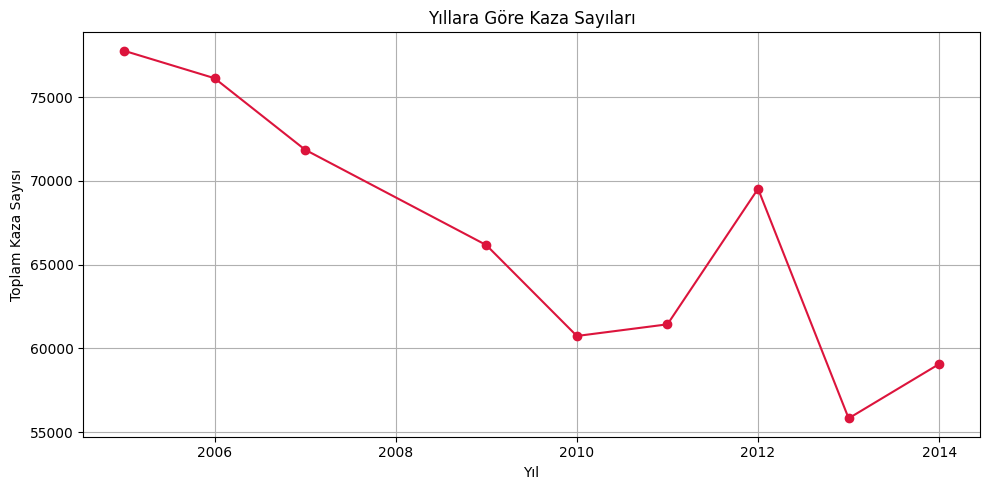

In [7]:
yillik_kaza = accidents_df['Yil'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.plot(yillik_kaza.index, yillik_kaza.values, marker='o', color='crimson')
plt.title("Yıllara Göre Kaza Sayıları")
plt.xlabel("Yıl")
plt.ylabel("Toplam Kaza Sayısı")
plt.grid(True)
plt.tight_layout()
plt.show()


**Yol Tipine Göre Kazaların Dağılımı**

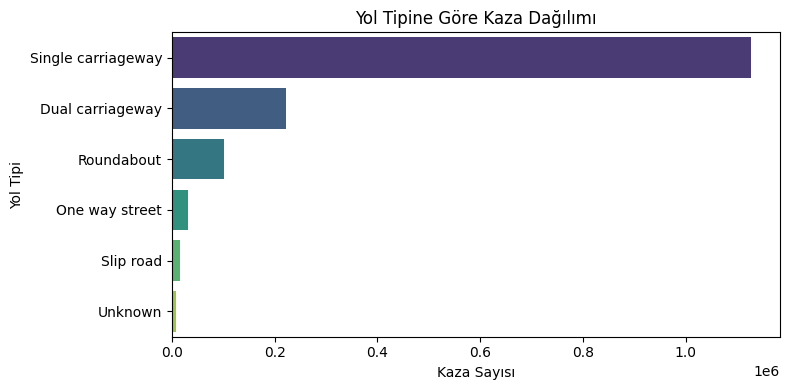

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(data=accidents_df, y='Road_Type', order=accidents_df['Road_Type'].value_counts().index, palette="viridis")
plt.title("Yol Tipine Göre Kaza Dağılımı")
plt.xlabel("Kaza Sayısı")
plt.ylabel("Yol Tipi")
plt.tight_layout()
plt.show()


**Trafik Akışı (AADF) ile İlişkilendirme**

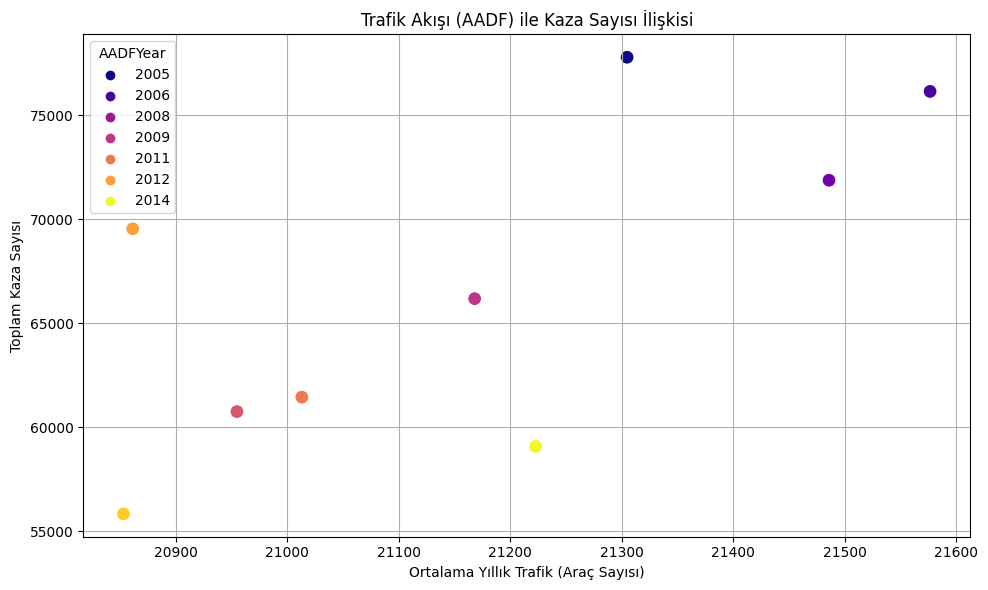

In [12]:
# Trafik verisinde 'AADFYear' sütununa göre yıllık ortalama trafik (AADF) hesaplama
trafik_ortalama = traffic_data.groupby("AADFYear")["AllMotorVehicles"].mean().reset_index()

# Kazaları yıllara göre gruplama
kaza_ortalama = accidents_df.groupby("Yil").size().reset_index(name="Kaza_Sayisi")

# Ortak yıl bilgisine göre iki veriyi birleştirme
birlesik = pd.merge(trafik_ortalama, kaza_ortalama, left_on="AADFYear", right_on="Yil")

# Görselleştirme
plt.figure(figsize=(10,6))
sns.scatterplot(data=birlesik, x="AllMotorVehicles", y="Kaza_Sayisi", hue="AADFYear", palette="plasma", s=100)
plt.title("Trafik Akışı (AADF) ile Kaza Sayısı İlişkisi")
plt.xlabel("Ortalama Yıllık Trafik (Araç Sayısı)")
plt.ylabel("Toplam Kaza Sayısı")
plt.grid(True)
plt.tight_layout()
plt.show()


**Basit Doğrusal Regresyon Modeli (Yıllık Tahmin)**

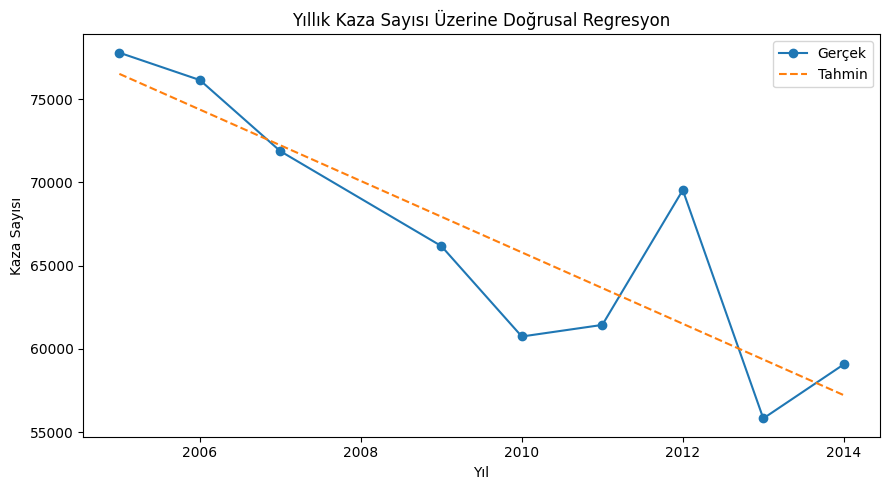

Model Doğruluk Skoru (R²): 0.7557255713649486


In [15]:
from sklearn.linear_model import LinearRegression

# X ekseni: AADFYear (trafik yılı)
X = np.array(birlesik["AADFYear"]).reshape(-1, 1)

# y ekseni: Kaza sayısı
y = birlesik["Kaza_Sayisi"].values

# Modeli oluştur ve eğit
model = LinearRegression()
model.fit(X, y)

# Tahminleri al
tahmin = model.predict(X)

# Görselleştirme
plt.figure(figsize=(9,5))
plt.plot(birlesik["AADFYear"], y, label="Gerçek", marker="o")
plt.plot(birlesik["AADFYear"], tahmin, label="Tahmin", linestyle="--")
plt.title("Yıllık Kaza Sayısı Üzerine Doğrusal Regresyon")
plt.xlabel("Yıl")
plt.ylabel("Kaza Sayısı")
plt.legend()
plt.tight_layout()
plt.show()

print("Model Doğruluk Skoru (R²):", model.score(X, y))
